In [1]:
%load_ext autoreload
%autoreload 2

import urllib.request as urllib2
from io import BytesIO
from zipfile import ZipFile

import numpy as np
import pandas as pd

# loading in the data

In [2]:
zip_url: str = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
zipped_file_name: str = "household_power_consumption.txt"


df_power_consumption: pd.DataFrame = pd.read_csv(
    ZipFile(BytesIO(urllib2.urlopen(zip_url).read())).open(zipped_file_name),
    sep=";",
    parse_dates={"timestamp": ["Date", "Time"]},
    infer_datetime_format=True,
    low_memory=False,
    na_values=["nan", "?"],
    index_col="timestamp",
    dtype="float32",
)

df_power_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float32
 1   Global_reactive_power  float32
 2   Voltage                float32
 3   Global_intensity       float32
 4   Sub_metering_1         float32
 5   Sub_metering_2         float32
 6   Sub_metering_3         float32
dtypes: float32(7)
memory usage: 71.2 MB


In [3]:
df_power_consumption.sample(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2008-05-25 09:44:00,0.678,0.150,237.690002,3.0,0.0,1.0,1.0
2009-09-06 21:38:00,2.616,0.328,239.720001,11.0,0.0,1.0,19.0


In [4]:
df_power_consumption.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
df_power_consumption.shape

(2075259, 7)

In [6]:
# so the data is actually regularly sampled
df_power_consumption.index.to_series().diff().value_counts()

0 days 00:01:00    2075258
Name: timestamp, dtype: int64

In [7]:
# but if we drop the nan's, this will not be the case
df_power_consumption = df_power_consumption.dropna()
df_power_consumption.index.to_series().diff().value_counts().sample(3)

0 days 00:03:00    14
0 days 01:24:00     1
2 days 14:04:00     1
Name: timestamp, dtype: int64

In [8]:
df_power_consumption.sample(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2009-01-01 02:15:00,0.564,0.064,246.119995,2.4,0.0,1.0,0.0
2009-10-07 13:46:00,0.506,0.066,243.080002,2.0,0.0,0.0,1.0


**global variables**:
* `global_active_power`: household global **minute averaged** active power (kilowatt)
* `global_reactive_power`: household global **minute averaged** reactive power (kilowatt)
* `global_intensity`: household global **minute averaged** current (ampere)
* `voltage`: minute-averaged voltage (volt)

**sub meterings**:
* `sub_metering_1`: **kitchen** - dishwasher & microwave - (in watt-hour of **active energy**)
* `sub_metering_2`: **laundry room** - washing maching, tumble drier, refrigerator & light (in watt-hour of **active energy**)
* `sub_metering_3`: electric water-heater & air conditioner (in watt-hour of **active energy**)


As the user is only billed for the **active power**, we will use this variable as target.

In [9]:
corr = df_power_consumption.corr() * np.tril(
    np.ones(tuple([len(df_power_consumption.columns)] * 2)), k=-1
)
pd.set_option("precision", 3)
corr.style.background_gradient(cmap="coolwarm", axis=None)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,0.000,0.000,-0.000,0.000,0.000,0.000,0.000
Global_reactive_power,0.247,0.000,-0.000,0.000,0.000,0.000,0.000
Voltage,-0.400,-0.112,0.000,-0.000,-0.000,-0.000,-0.000
Global_intensity,0.999,0.266,-0.411,0.000,0.000,0.000,0.000
Sub_metering_1,0.484,0.123,-0.196,0.489,0.000,0.000,0.000
Sub_metering_2,0.435,0.139,-0.167,0.440,0.055,0.000,0.000
Sub_metering_3,0.639,0.090,-0.268,0.627,0.103,0.081,0.000


Our objective is:
> To estimate the average `Global active power` over the last 15 minutes by **only** using current or past sub-metering values.

**remark**:
We explicitly did not use global variables (like `global_intensity`) as these are show high correlations with the global power consumption.

In [10]:
# create the target
df_power_consumption["avg_15min_GAP"] = df_power_consumption.rolling("15min")[
    "Global_active_power"
].aggregate(np.nanmean)

# EDA

`TODO`

# ML time

## train-test split

In [11]:
train_columns = [f"Sub_metering_{i}" for i in range(1, 4)] + ["timestamp"]
target_col = "avg_15min_GAP"

# The percentage of data used for testing
test_pct = 0.2
day_margin = 3

# add the timestamp col
df_power_consumption["timestamp"] = df_power_consumption.index

# Temporal split: Use the last test_pct of the data as test_data
df_train = df_power_consumption[: -int(len(df_power_consumption) * test_pct)].copy()
X_train, y_train = df_train[train_columns], df_train[target_col]

df_test = df_power_consumption[df_train.index[-1] + pd.Timedelta(days=day_margin) :]
X_test, y_test = df_test[train_columns], df_test[target_col]

In [12]:
import sys
sys.path.append("../")

In [13]:
import scipy.stats as ss

from tsflex.chunking import chunk_data
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.utils import make_robust

## Feature extraction with tsflex

In [14]:
def slope(x): return (x[-1] - x[0]) / x[0] if x[0] else 0
def abs_diff_mean(x): return np.mean(np.abs(x[1:] - x[:-1])) if len(x) > 1 else 0
def diff_std(x): return np.std(x[1:] - x[:-1]) if len(x) > 1 else 0

# time based features
def time_float(x):
    x_ = pd.Timestamp(x[-1])
    return np.float32(x_.hour + x_.minute / 60)
def day_of_week(x): return pd.Timestamp(x[-1]).day_of_week


funcs = [make_robust(f) for f in [np.min, np.max, np.std, np.mean, slope, ss.skew, abs_diff_mean, diff_std, sum, len,]]
time_funcs = [make_robust(f) for f in [time_float, day_of_week]]

# Create the feature collection
fc = FeatureCollection(
    feature_descriptors=[
        MultipleFeatureDescriptors(
            functions=funcs,
            series_names=list(set(train_columns).difference({"timestamp"})),
            windows=["15min", "30min", "1h"],
            strides="15min",
        ),
        MultipleFeatureDescriptors(
            functions=time_funcs,
            series_names="timestamp",
            windows=["15min"],
            strides="15min",
        ),
    ]
)
fc

Sub_metering_1: (
	win: 15m   , stride: 15m: [
		FeatureDescriptor - func: FuncWrapper([robust]__amin, ['amin'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__amax, ['amax'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__slope, ['slope'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__abs_diff_mean, ['abs_diff_mean'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__diff_std, ['diff_std'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__sum, ['sum'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__len, ['len'], {}),
	]
	win: 30m   , stride: 15m: [
		FeatureDescriptor - func: FuncWrapper([robust]__amin, ['amin'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__amax, ['amax'], {}),
		FeatureDescriptor - func: FuncWrapper([robust

### Chunking train data

In [15]:
# %%time
# chunk the data in blocks of `max_chunk_dur`
chunks = chunk_data(
    data=df_train,
    max_chunk_dur="365 days",
    chunk_range_margin="10 min",
    sub_chunk_overlap="15min",
)

we will now use these yearly chunks to extract the features

In [16]:
df_train_feats = pd.concat(
    [
        fc.calculate(chunk, show_progress=True, return_df=True, approve_sparsity=True)
        for chunk in chunks
    ]
)

100%|██████████| 92/92 [00:02<00:00, 43.98it/s]


In [17]:
df_train_feats.sample(2)

,Sub_metering_2__len__w=15m_s=15m,Sub_metering_2__slope__w=15m_s=15m,Sub_metering_2__amax__w=15m_s=15m,Sub_metering_2__amin__w=15m_s=15m,Sub_metering_2__amax__w=30m_s=15m,Sub_metering_2__slope__w=30m_s=15m,Sub_metering_2__amin__w=30m_s=15m,Sub_metering_2__sum__w=15m_s=15m,Sub_metering_2__len__w=30m_s=15m,Sub_metering_2__mean__w=15m_s=15m,...,Sub_metering_3__diff_std__w=30m_s=15m,timestamp__day_of_week__w=15m_s=15m,Sub_metering_3__sum__w=1h_s=15m,Sub_metering_3__std__w=1h_s=15m,Sub_metering_3__diff_std__w=1h_s=15m,Sub_metering_1__skew__w=30m_s=15m,Sub_metering_1__skew__w=1h_s=15m,Sub_metering_3__skew__w=15m_s=15m,Sub_metering_3__skew__w=30m_s=15m,Sub_metering_3__skew__w=1h_s=15m
timestamp,,,,,,,,,,,,,,,,,,,,,
2007-11-24 07:54:00,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.000,5.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2007-06-03 21:09:00,15.0,0.0,2.0,1.0,2.0,0.0,1.0,18.0,30.0,1.2,...,3.012,6.0,420.0,8.256,2.132,0.933,2.005,-1.055,-1.769,0.342


In [18]:
# make sure that there are no duplicate indices
print(df_train_feats.shape)
df_train_feats = df_train_feats[~df_train_feats.index.duplicated()]
print(df_train_feats.shape)

(110060, 92)
(110060, 92)


## Constructing the pipeline

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [20]:
selected_cols = df_train_feats.columns
df_train = df_train_feats.join(y_train)
# drop the observations of which we don't have the target
df_train = df_train[df_train[y_train.name].notna()]

In [21]:
pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        (
            "br",
            BayesianRidge(),
        ),
    ]
)


# as this is a lot of data, this might take a minute or 5
pipe.fit(df_train[selected_cols], df_train[y_train.name])

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler()), ('br', BayesianRidge())])

---

## Prediction on `df_test`

In [22]:
df_test_feats = fc.calculate(
    df_test, show_progress=True, return_df=True, approve_sparsity=True
)

100%|██████████| 92/92 [00:13<00:00,  6.74it/s]


In [23]:
df_test_tot = df_test_feats.join(y_test)

In [24]:
out = pipe.predict(df_test_tot[selected_cols], return_std=True)
df_test_tot["predictions"] = out[0]
df_test_tot["std"] = out[1]

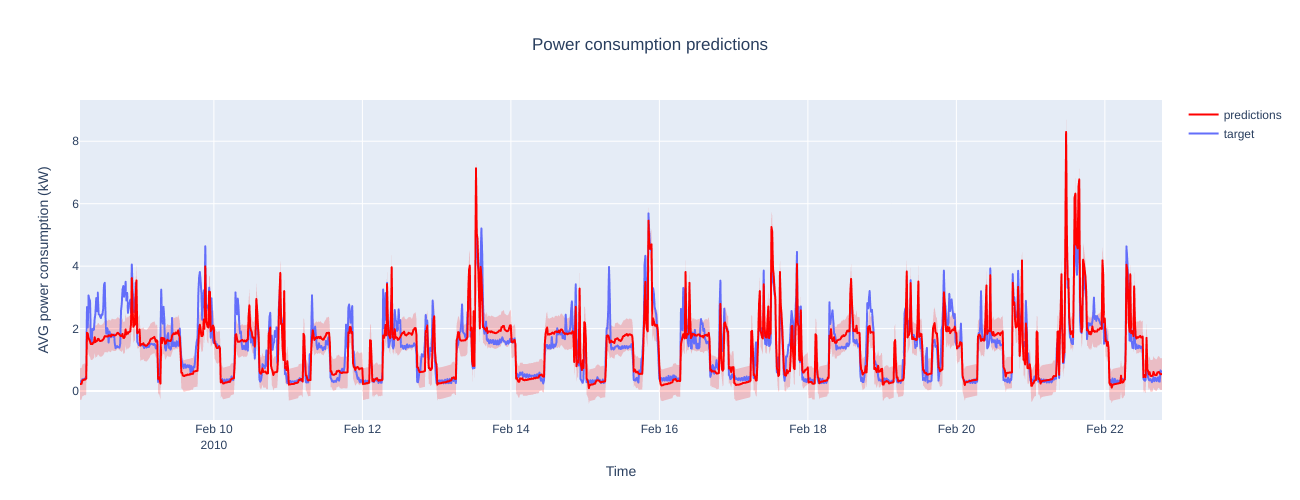

In [26]:
import plotly.graph_objects as go

size = 1400

fig = go.Figure()
fig.add_trace(
    go.Scattergl(
        x=df_test_tot.index[:size], y=df_test_tot[y_test.name][:size], name="target"
    )
)
fig.add_trace(
    go.Scattergl(
        x=df_test_tot.index[:size],
        y=df_test_tot.predictions[:size],
        name="predictions",
        marker_color="red",
    )
)

# also visualize the lower and upper bounds; 
#   these values are the predictions +/- std, respetively

fig.add_trace(
    go.Scatter(
        x=df_test_tot.index[:size],
        y=df_test_tot.predictions[:size] + df_test_tot["std"][:size],
        name="upper_bound",
        showlegend=False,
        marker_color='black',
        line=dict(width=0),
        mode='lines',
    ),
)

fig.add_trace(
    go.Scatter(
        x=df_test_tot.index[:size],
        y=df_test_tot.predictions[:size] - df_test_tot["std"][:size],
        name="lower bound",
        showlegend=False,
        marker_color='black',
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(255, 0, 0, 0.2)',
        fill='tonexty'
    ),
)


fig.update_layout(title="Power consumption predictions", title_x=0.5, hovermode='x')
fig.update_xaxes(title="Time")
fig.update_yaxes(title="AVG power consumption (kW)")

fig.show(renderer="png", width=1300, height=500)